# ProGAN image generation on celebA dataset

This notebook tries to replicate the work done in the ProGAN paper: https://arxiv.org/pdf/1710.10196.pdf <br>
Link to the dataset used for training: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256 <br>
The dataset contains 30000 celebrity faces, resampled to 256px. <br>
This notebook is designed to generate images up to resolution 256px, due to the limitation of computing power, it only goes to 128px.

Visualize the data

In [107]:
from math import log2
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [108]:
DATASET                 = '/content/celeba_hq_256'
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda"
LEARNING_RATE           = 2e-4
BATCH_SIZES             = [32, 32, 32, 32, 32, 32, 16]
image_size              = 256
CHANNELS_IMG            = 3
Z_DIM                   = 256  
IN_CHANNELS             = 512  
PROGRESSIVE_EPOCHS      = [30, 60, 120, 150, 200, 210, 300]

In [109]:
def show_tensor_images(image_tensor, num_images=5, nrow=5, figsize=(15,15)):
    image_shifted = (image_tensor + 1) / 2
    image_grid = make_grid(image_shifted[:num_images].detach().cpu(), nrow=nrow)
    plt.figure(figsize = figsize)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [110]:
class FacesDataset(torch.utils.data.Dataset):
    def __init__(self, transform): 
        def get_images():
            images = [x for x in os.listdir(DATASET) if x.lower().endswith('jpg')]
            return images
          
        self.images = get_images()
        self.transform = transform
        
        
    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join('celeba_hq_256', image_name)
        image = Image.open(image_path)
        return self.transform(image)

In [111]:
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = FacesDataset(transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset

In [112]:
loader, dataset = get_loader(256)

In [113]:
print("Number of images for training: {}".format(len(dataset)))

Number of images for training: 30000


Examples of training images, 256px


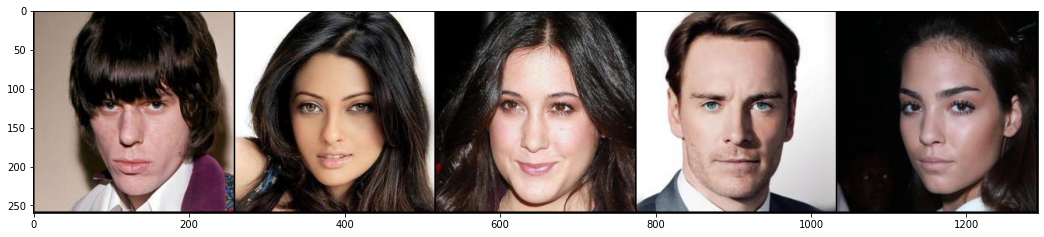

In [114]:
dataiter = iter(loader)
images = next(dataiter)
print("Examples of training images, 256px")
show_tensor_images(images, num_images=5, nrow=5, figsize=(18,18))

Building blocks for the model

In [124]:
factors = [1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

Generator

In [125]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return torch.tanh(self.initial_rgb(out))

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

Discriminator

In [126]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)


        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  
        self.final_block = nn.Sequential(
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ), 
        )

    def fade_in(self, alpha, downscaled, out):

        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )

        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):

        cur_step = len(self.prog_blocks) - steps


        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)


        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))


        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

Training function

For better numerical stability, I used BCE loss rather than Wasserstein loss

In [127]:
def train_fn(
    disc,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_disc,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, real in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        disc_real = disc(real, alpha, step)
        disc_fake = disc(fake.detach(), alpha, step)

        loss_disc_real = nn.BCEWithLogitsLoss()(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = nn.BCEWithLogitsLoss()(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2.0

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        gen_fake = disc(fake, alpha, step)
        loss_gen = nn.BCEWithLogitsLoss()(gen_fake, torch.ones_like(gen_fake))

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        
        alpha = min(alpha, 1.0)

        loop.set_postfix(
            loss_gen=loss_gen.item(),
            loss_disc=loss_disc.item(),
            alpha = alpha
        )
    return alpha, real, fake, loss_gen.item(), loss_disc.item()

Initialization

In [128]:
gen = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
disc = Discriminator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)

gen_opt = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_opt = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0., 0.02)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [129]:
START_TRAIN_AT_IMG_SIZE = 4

Training

In [ ]:
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-4
    loader, dataset = get_loader(4 * 2 ** step)  
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha, real, fake, loss_gen, loss_critic = train_fn(
            disc,
            gen,
            loader,
            dataset,
            step,
            alpha,
            disc_opt,
            gen_opt,
        )
              
    print("Step {} finished".format(step))
    step += 1

Below shows the images generated by generators at 4px, 8px, 16px, 32px, 64px, and 128px <br>
All the generators use my pretrained weights saved in my google drive <br>
For the purpose of presentation, all the generators use the same, selected random noises

In [39]:
selected_noises = torch.load('/content/drive/MyDrive/ProGAN/Selected noises.pt')

Generator 4px

In [131]:
gen_4px = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
loaded_state_4px = torch.load('/content/drive/MyDrive/ProGAN/ProGAN_4px.pt')
gen_4px.load_state_dict(loaded_state_4px["gen"])
gen_4px.eval();

Real images 4px


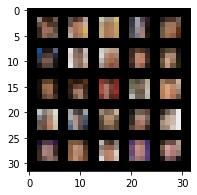

In [132]:
print("Real images 4px")
loader_test, dataset_test = get_loader(4)
dataiter = iter(loader_test)
images = next(dataiter)
show_tensor_images(images, num_images=25, nrow=5, figsize=(3,3))

Generated images 4px


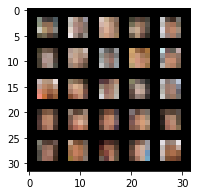

In [133]:
print("Generated images 4px")
with torch.no_grad():
    img = gen_4px(selected_noises.to(DEVICE), 1, 0)
    show_tensor_images(img, num_images=25, nrow=5, figsize=(3,3))

Generator 8px

In [134]:
gen_8px = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
loaded_state_8px = torch.load('/content/drive/MyDrive/ProGAN/ProGAN_8px.pt')
gen_8px.load_state_dict(loaded_state_8px["gen"])
gen_8px.eval();

Real images 8px


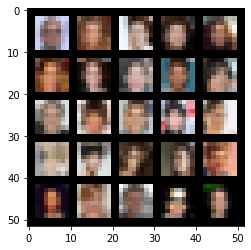

In [135]:
print("Real images 8px")
loader_test, dataset_test = get_loader(8)
dataiter = iter(loader_test)
images = next(dataiter)
show_tensor_images(images, num_images=25, nrow=5, figsize=(4,4))

Generated images 8px


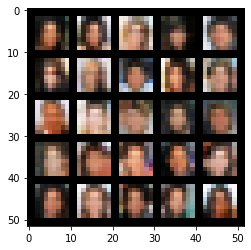

In [140]:
print("Generated images 8px")
with torch.no_grad():
    img = gen_8px(selected_noises.to(DEVICE), 1, 1)
    show_tensor_images(img, num_images=25, nrow=5, figsize=(4,4))

Generator 16px

In [144]:
gen_16px = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
loaded_state_16px = torch.load('/content/drive/MyDrive/ProGAN/ProGAN_16px.pt')
gen_16px.load_state_dict(loaded_state_16px["gen"])
gen_16px.eval();

Real images 16px


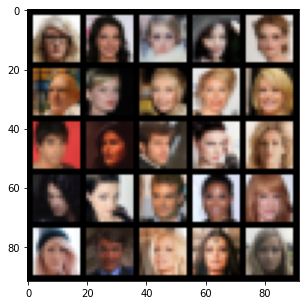

In [145]:
print("Real images 16px")
loader_test, dataset_test = get_loader(16)
dataiter = iter(loader_test)
images = next(dataiter)
show_tensor_images(images, num_images=25, nrow=5, figsize=(5,5))

Generated images 16px


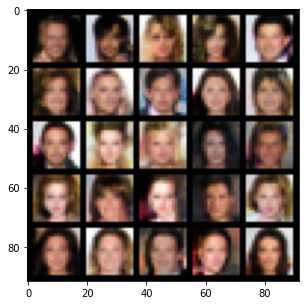

In [146]:
print("Generated images 16px")
with torch.no_grad():
    img = gen_16px(selected_noises.to(DEVICE), 1, 2)
    show_tensor_images(img, num_images=25, nrow=5, figsize=(5,5))

Generator 32px

In [147]:
gen_32px = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
loaded_state_32px = torch.load('/content/drive/MyDrive/ProGAN/ProGAN_32px.pt')
gen_32px.load_state_dict(loaded_state_32px["gen"])
gen_32px.eval();

Real images 32px


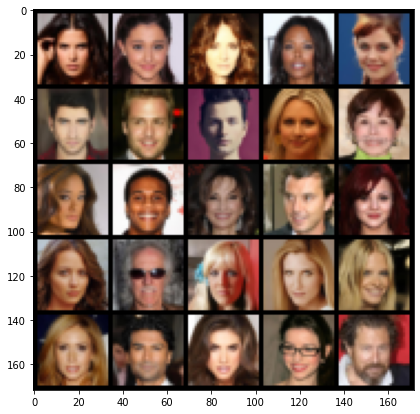

In [149]:
print("Real images 32px")
loader_test, dataset_test = get_loader(32)
dataiter = iter(loader_test)
images = next(dataiter)
show_tensor_images(images, num_images=25, nrow=5, figsize=(7,7))

Generated images 32px


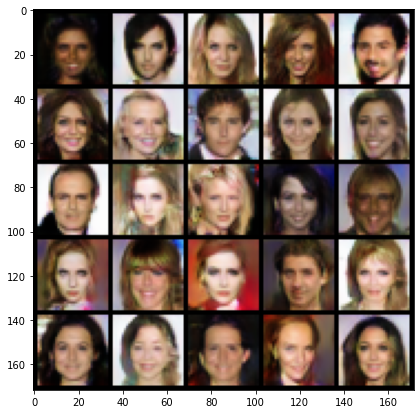

In [151]:
print("Generated images 32px")
with torch.no_grad():
    img = gen_32px(selected_noises.to(DEVICE), 1, 3)
    show_tensor_images(img, num_images=25, nrow=5, figsize=(7,7))

Generator 64px

In [152]:
gen_64px = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
loaded_state_64px = torch.load('/content/drive/MyDrive/ProGAN/ProGAN_64px.pt')
gen_64px.load_state_dict(loaded_state_64px["gen"])
gen_64px.eval();

Real images 64px


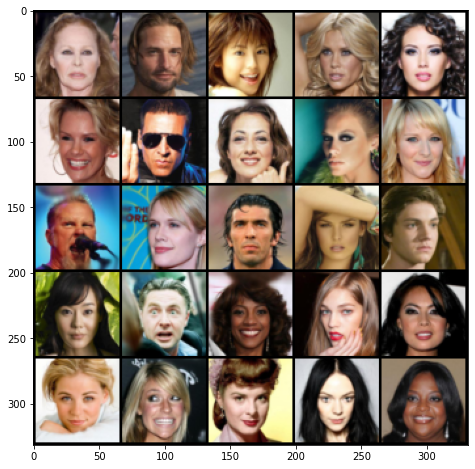

In [153]:
print("Real images 64px")
loader_test, dataset_test = get_loader(64)
dataiter = iter(loader_test)
images = next(dataiter)
show_tensor_images(images, num_images=25, nrow=5, figsize=(8,8))

Generated images 64px


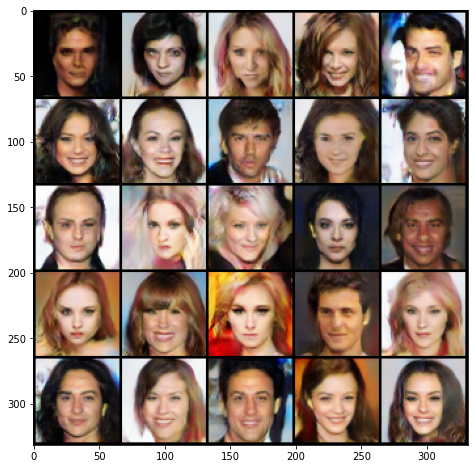

In [154]:
print("Generated images 64px")
with torch.no_grad():
    img = gen_64px(selected_noises.to(DEVICE), 1, 4)
    show_tensor_images(img, num_images=25, nrow=5, figsize=(8,8))

Generator 128px

In [155]:
gen_128px = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
loaded_state_128px = torch.load('/content/drive/MyDrive/ProGAN/ProGAN_128px.pt')
gen_128px.load_state_dict(loaded_state_128px["gen"])
gen_128px.eval();

Real images 128px


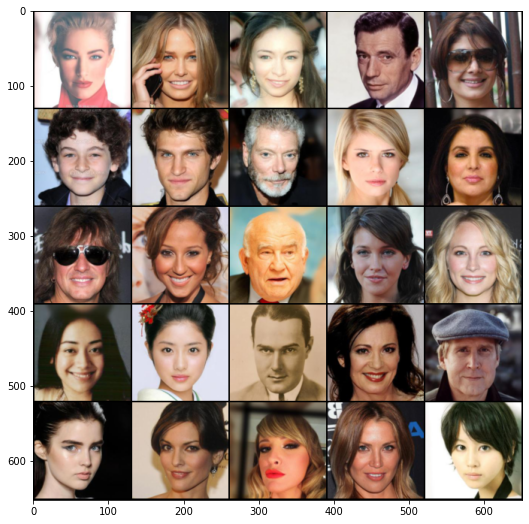

In [156]:
print("Real images 128px")
loader_test, dataset_test = get_loader(128)
dataiter = iter(loader_test)
images = next(dataiter)
show_tensor_images(images, num_images=25, nrow=5, figsize=(9,9))

Generated images 128px


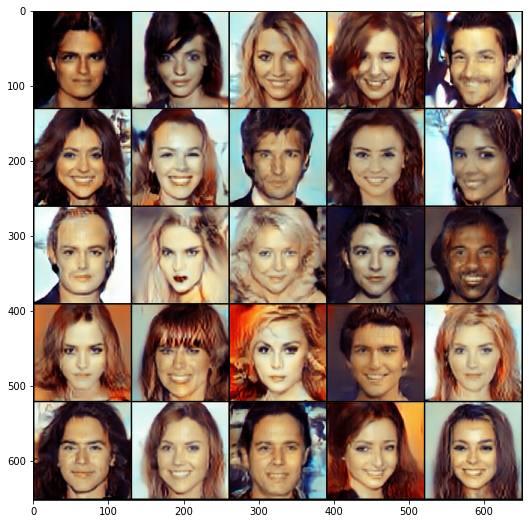

In [158]:
print("Generated images 128px")
with torch.no_grad():
    img = gen_128px(selected_noises.to(DEVICE), 1, 5)
    show_tensor_images(img, num_images=25, nrow=5, figsize=(9,9))